In [156]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

# Galaxy Shapes

Here I calculate an ellipsodal shape for stellar particles in Illustris galaxies.

## Choose Galaxy

In [256]:
# specify simulation
simname = 'Illustris-1'
snapNum = 135

# load simulation information
from Illustris_Shapes.simulation_props import sim_prop_dict
d = sim_prop_dict[simname]
basePath = d['basePath']
Lbox = d['Lbox']

In [266]:
# load shape catalog
from astropy.table import Table
fname = simname + '_' + str(snapNum) + '_' + 'reduced' + '_' +'galaxy_shapes'+ '.dat' 
t_1 = Table.read('../data/shape_catalogs/'+fname, format='ascii')
t_1['gal_id']

# choose a galaxy
i = 9
gal_id = t_1['gal_id'][i]

## Calculate a Shape

In [267]:
from Illustris_Shapes.calculate_galaxy_shapes import galaxy_selection, galaxy_center
from Illustris_Shapes.calculate_galaxy_shapes import particle_selection, format_particles
from inertia_tensors import inertia_tensors, reduced_inertia_tensors, iterative_inertia_tensors_3D
from illustris_python.snapshot import loadHalo, snapPath, loadSubhalo
from illustris_python.groupcat import gcPath, loadHalos, loadSubhalos, loadHeader

In [268]:
# load galaxy table
fields = ['SubhaloGrNr', 'SubhaloMassInRadType', 'SubhaloPos', 'SubhaloHalfmassRadType']
galaxy_table = loadSubhalos(basePath, snapNum, fields=fields)

In [269]:
shape_type = 'iterative'

# choose a 'center' for each galaxy
gal_position = galaxy_center(gal_id, galaxy_table)

# load stellar particle positions and masses
ptcl_coords = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Coordinates'])/1000.0
ptcl_masses = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Masses'])*10.0**10

# center and account for PBCs
ptcl_coords = format_particles(gal_position, ptcl_coords, Lbox)

# get the half mass radius
gal_rhalfs = loadSubhalos(basePath, snapNum, fields=['SubhaloHalfmassRadType'])[:,4]/1000.00
gal_rhalf = gal_rhalfs[gal_id]

# make a selection cut on the particles
if shape_type=='non-reduced':
    ptcl_mask = particle_selection(gal_id, ptcl_coords, galaxy_table, basePath, snapNum, radial_mask=True)
else:
    ptcl_mask = particle_selection(gal_id, ptcl_coords, galaxy_table,  basePath, snapNum, radial_mask=True)

if shape_type == 'reduced':
    I = reduced_inertia_tensors(ptcl_coords[ptcl_mask], ptcl_masses[ptcl_mask])
elif shape_type == 'non-reduced':
    I = inertia_tensors(ptcl_coords[ptcl_mask], ptcl_masses[ptcl_mask])
elif shape_type == 'iterative':
    I = iterative_inertia_tensors_3D(ptcl_coords[ptcl_mask], ptcl_masses[ptcl_mask], rtol=0.01, niter_max=10)
else:
    msg = ('tensor calculation type not recognized.')
    raise ValueError(msg)

evals, evecs = np.linalg.eigh(I)
evals = np.sqrt(evals)

In [270]:
a = evals[0][2]
b = evals[0][1]
c = evals[0][0]
major = evecs[0][2]
inter = evecs[0][1]
minor = evecs[0][0]

## plot galaxy

Here I plot the galaxy using three different projections.  I overplot a shape ellipse by projecting the 3D shape ellipsoid along the projected axis in each panel.  You will need to define the projection function in the block below before running this block.

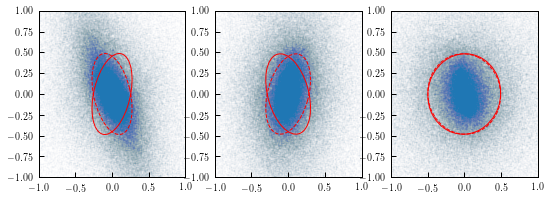

In [275]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

fig, axes = plt.subplots(1,3, figsize=(3.3*3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

ax = axes[0]
proj_b_to_a, theta = projected_shape(major, inter, minor, b/a, c/a, u_los=[0.0,0.0,1.0])
ellipse_a = Ellipse([0,0], 1, proj_b_to_a, angle=np.degrees(theta), facecolor='none', edgecolor='red')
ellipse_b = Ellipse([0,0], 1, proj_b_to_a, angle=180-np.degrees(theta), facecolor='none', edgecolor='red', ls='--')
ax.scatter(ptcl_coords[:,0]/gal_rhalf, ptcl_coords[:,1]/gal_rhalf, s=1, alpha=0.01)
ax.add_artist(ellipse_a)
ax.add_artist(ellipse_b)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = axes[1]
proj_b_to_a, theta = projected_shape(major, inter, minor, b/a, c/a, u_los=[0.0,1.0,0.0])
ellipse_a = Ellipse([0,0], 1, proj_b_to_a, angle=np.degrees(theta), facecolor='none', edgecolor='red')
ellipse_b = Ellipse([0,0], 1, proj_b_to_a, angle=180-np.degrees(theta), facecolor='none', edgecolor='red', ls='--')
ax.scatter(ptcl_coords[:,0]/gal_rhalf, ptcl_coords[:,2]/gal_rhalf, s=1, alpha=0.01)
ax.add_artist(ellipse_a)
ax.add_artist(ellipse_b)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = axes[2]
proj_b_to_a, theta = projected_shape(major, inter, minor, b/a, c/a, u_los=[1.0,0.0,0.0])
ellipse_a = Ellipse([0,0], 1, proj_b_to_a, angle=np.degrees(theta), facecolor='none', edgecolor='red')
ellipse_b = Ellipse([0,0], 1, proj_b_to_a, angle=180-np.degrees(theta), facecolor='none', edgecolor='red', ls='--')
ax.scatter(ptcl_coords[:,1]/gal_rhalf, ptcl_coords[:,2]/gal_rhalf, s=1, alpha=0.01)
ax.add_artist(ellipse_a)
ax.add_artist(ellipse_b)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

plt.show()

In [204]:
from rotations.vector_utilities import angles_between_list_of_vectors

def projected_shape(major, inter, minor, b_to_a, c_to_a, u_los=[0.0, 0.0, 1.0]):
    r"""
    """

    u_los = np.atleast_1d(u_los)
    major = np.atleast_1d(major)
    inter = np.atleast_1d(inter)
    minor = np.atleast_1d(minor)

    # calculate inclination angle
    theta = np.arccos(np.dot(minor, u_los))

    # calculate major-axis orientation angle
    u_n = np.cross(minor, u_los)
    u_n = u_n/np.sqrt(np.sum(u_n**2))
    phi = angles_between_list_of_vectors(major, u_n, vn=minor) + np.pi

    # calulate projected axis ratio
    proj_b_to_a = projected_b_to_a(b_to_a, c_to_a, theta, phi)
    
    return proj_b_to_a[0], theta

def projected_b_to_a(b_to_a, c_to_a, theta, phi):
    r"""
    Calulate the projected minor-to-major semi-axis lengths ratios
    for the 2D projectyion of an 3D ellipsodial distributions.
    Parameters
    ----------
    b_to_a : array_like
        array of intermediate axis ratios, b/a
    c_to_a : array_like
        array of minor axis ratios, c/a
    theta : array_like
        orientation angle, where cos(theta) is bounded between :math:`[0,1]`
    phi : array_like
        orientation angle, where phi is bounded between :math:`[0,2\pi]`
    
    Returns
    -------
    proj_b_to_a : numpy.array
        array of projected minor-to-major axis ratios
   
    Notes
    -----
    For combinations of axis ratios and orientations that result in a sufficiently high
    projected ellipticity, numerical errors cause the projected axis ratio to be 
    approximated as 0.0.  
    """

    b_to_a = np.atleast_1d(b_to_a)
    c_to_a = np.atleast_1d(c_to_a)
    theta = np.atleast_1d(theta)
    phi = np.atleast_1d(phi)
    
    # gamma
    g = c_to_a
    # ellipticity
    e = 1.0 - b_to_a

    V = (1 - e*(2 - e)*np.sin(phi)**2)*np.cos(theta)**2 + g**2*np.sin(theta)**2
    W = 4*e**2*(2-e)**2*np.cos(theta)**2*np.sin(phi)**2*np.cos(phi)**2
    Z = 1-e*(2-e)*np.cos(phi)**2
    
    # for very high ellipticity, e~1
    # numerical errors become an issue
    with np.errstate(invalid='ignore'):
        projected_b_to_a = np.sqrt((V+Z-np.sqrt((V-Z)**2+W))/(V+Z+np.sqrt((V-Z)**2+W)))
        
    # set b_to_a to 0.0 in this case
    return np.where(np.isnan(projected_b_to_a), 0.0, projected_b_to_a)